In [1]:
import torch
import numpy as np

from pathlib2 import Path
from omegaconf import OmegaConf

from tqdm.notebook import tqdm 

from src.data.bottleneck_code.dataset import load_data
from src.data.process_dataset import get_meta

In [2]:
args = OmegaConf.create({
    'use_attr': True,
    'no_img': False,
    'batch_size': 64,
    'uncertain_labels': False,
    'image_dir': r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\data\raw\CUB_200_2011\CUB_200_2011\images",
    'n_class_attr': 2,
    'resampling': False,
})

In [3]:
BASE_DIR        = Path(r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI")

train_data_path = (BASE_DIR / 'data/processed/CUB_200_2011/bottleneck/train.pkl').as_posix()
val_data_path   = (BASE_DIR / 'data/processed/CUB_200_2011/bottleneck/val.pkl').as_posix()
test_data_path  = (BASE_DIR / 'data/processed/CUB_200_2011/bottleneck/test.pkl').as_posix()

train_loader = load_data(
    [train_data_path], 
    args.use_attr, 
    args.no_img, 
    args.batch_size, 
    args.uncertain_labels, 
    image_dir=args.image_dir,
    n_class_attr=args.n_class_attr, 
    resampling=args.resampling
)

val_loader = load_data(
    [val_data_path], 
    args.use_attr, 
    args.no_img, 
    args.batch_size, 
    args.uncertain_labels, 
    image_dir=args.image_dir,
    n_class_attr=args.n_class_attr, 
    resampling=args.resampling
)

test_loader = load_data(
    [test_data_path], 
    args.use_attr, 
    args.no_img, 
    args.batch_size, 
    args.uncertain_labels, 
    image_dir=args.image_dir,
    n_class_attr=args.n_class_attr, 
    resampling=args.resampling
)

In [60]:
imgs, labels, concepts = [], [], torch.tensor([]) 

for batch_imgs, batch_labels, batch_concepts in tqdm(iter(train_loader)):
    concepts = torch.concat([concepts, torch.stack(batch_concepts)], axis=1)
    labels.extend(batch_labels)
    imgs.extend(batch_imgs)
    
imgs = torch.stack(imgs)

  0%|          | 0/74 [00:00<?, ?it/s]

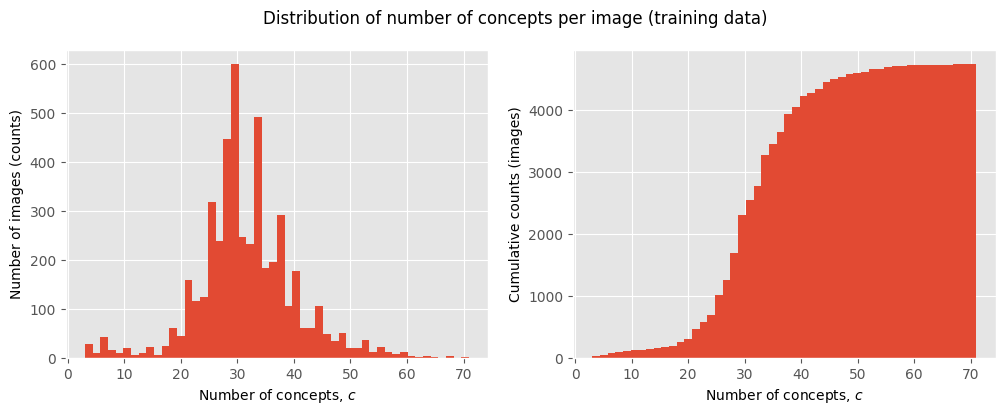

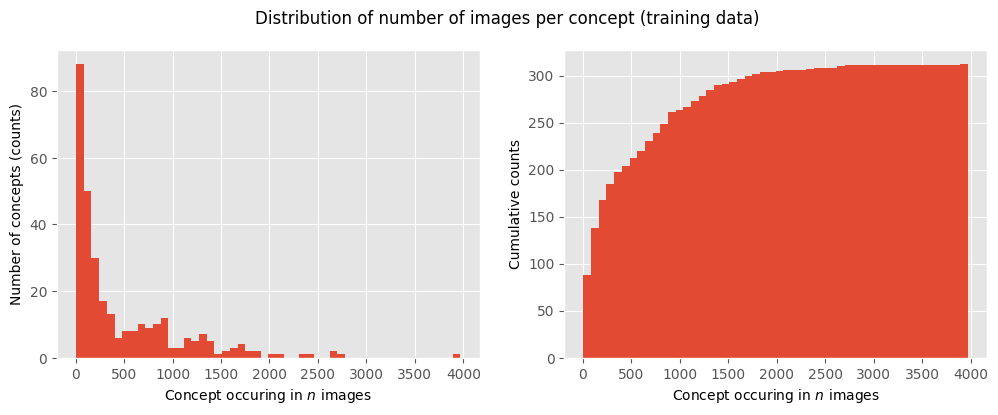

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

concepts_per_image = concepts.sum(axis=0).numpy()
images_per_concept = concepts.sum(axis=1).numpy()

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axs[0].hist(concepts_per_image, bins=50)
axs[0].set_xlabel('Number of concepts, $c$')
axs[0].set_ylabel('Number of images (counts)')

axs[1].hist(concepts_per_image, bins=50, cumulative=True)
axs[1].set_xlabel('Number of concepts, $c$')
axs[1].set_ylabel('Cumulative counts (images)')

fig.suptitle("Distribution of number of concepts per image (training data)")
plt.show()


fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axs[0].hist(images_per_concept, bins=50)
axs[0].set_xlabel('Concept occuring in $n$ images')
axs[0].set_ylabel('Number of concepts (counts)')

axs[1].hist(images_per_concept, bins=50, cumulative=True)
axs[1].set_xlabel('Concept occuring in $n$ images')
axs[1].set_ylabel('Cumulative counts')

fig.suptitle("Distribution of number of images per concept (training data)")
plt.show()

In [55]:
# Get dictionaries of label and concept names
meta = get_meta(BASE_DIR / 'data/raw/CUB_200_2011/CUB_200_2011')

idx2concept = meta['concepts']['idx2concept']

In [56]:
dominating_concept = idx2concept[images_per_concept.argmax()].split("::")[0]
category_ = np.where([concept_.startswith(dominating_concept) for concept_ in idx2concept.values()])[0]

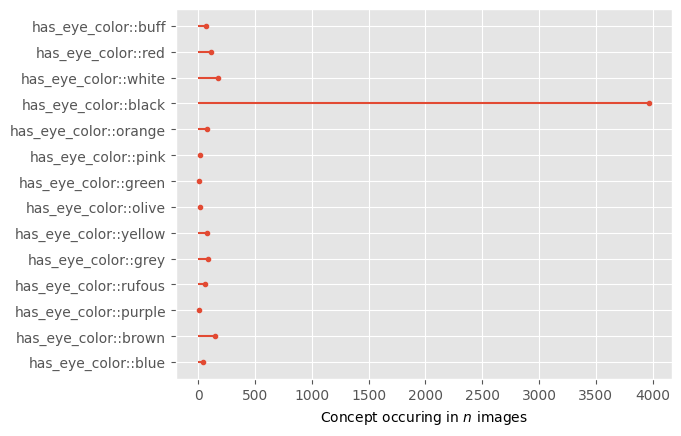

In [57]:
plt.plot(images_per_concept[category_], np.arange(len(category_)), '.')
plt.hlines(np.arange(len(category_)), 0, images_per_concept[category_])  # Stems

plt.xlabel('Concept occuring in $n$ images')
plt.yticks(np.arange(len(category_)), [idx2concept[concept_] for concept_ in category_])
plt.show()

In [80]:
from collections import Counter

label_dist = {k: v for k, v in sorted(Counter(torch.stack(labels).numpy()).items(), key=lambda x: x[0])}

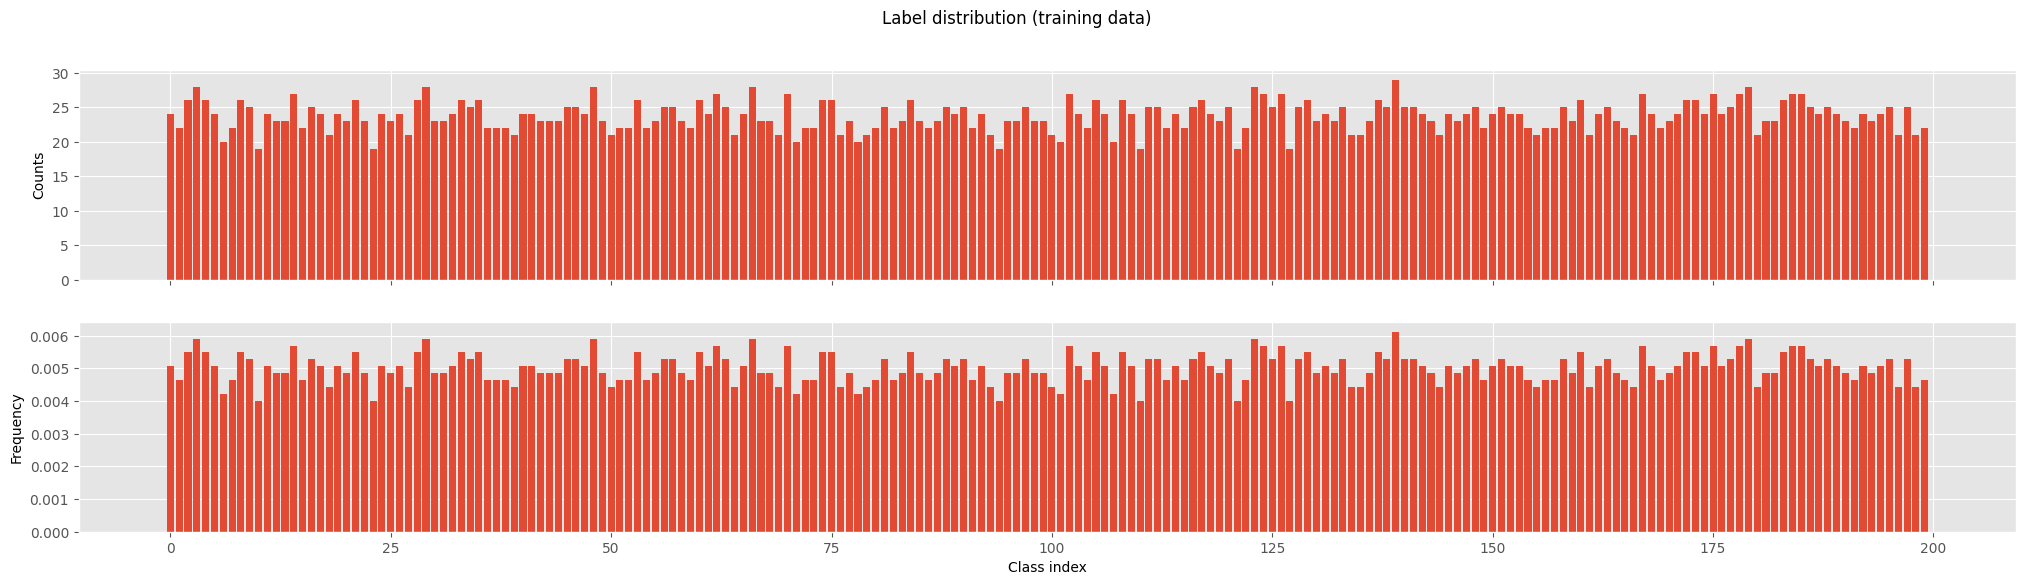

In [94]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(25, 6))

axs[0].bar(list(label_dist.keys()), np.array(list(label_dist.values())))
axs[0].set_ylabel('Counts')

axs[1].bar(list(label_dist.keys()), np.array(list(label_dist.values())) / len(labels))
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Class index')

fig.suptitle("Label distribution (training data)")
plt.show()